In [549]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
from sklearn.model_selection import train_test_split,KFold,cross_val_score,RandomizedSearchCV,cross_val_predict,StratifiedKFold
from sklearn.linear_model import LinearRegression,Ridge,Lasso
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics.scorer import make_scorer

In [550]:
train = pd.read_csv("train_fwYjLYX.csv",parse_dates=['application_date'])
test  = pd.read_csv("test_1eLl9Yf.csv",parse_dates=['application_date'])

In [551]:
print ("Shape of Training Data:{}".format(train.shape))
print ("Shape of Testing Data:{}".format(test.shape))

Shape of Training Data:(80402, 6)
Shape of Testing Data:(180, 3)


In [552]:
Submission = test[['id','application_date','segment']]
test.drop('id',axis=1,inplace=True)

### EDA- Train Data

In [553]:
train.info(memory_usage='deep')

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 80402 entries, 0 to 80401
Data columns (total 6 columns):
application_date    80402 non-null datetime64[ns]
segment             80402 non-null int64
branch_id           66898 non-null float64
state               80402 non-null object
zone                66898 non-null object
case_count          80402 non-null float64
dtypes: datetime64[ns](1), float64(2), int64(1), object(2)
memory usage: 11.9 MB


1. There are missing values in branch_id and zone variables.
2. application_date variable is read as datetime type.
3. Dependent variable does not have missing values. 

In [554]:
train['application_date'].max(), train['application_date'].min()
# Training data starts from 1st of April 2017 and ends at 23rd of July 2019. Roughly 2 years of data.

(Timestamp('2019-07-23 00:00:00'), Timestamp('2017-04-01 00:00:00'))

Text(0, 0.5, 'Count')

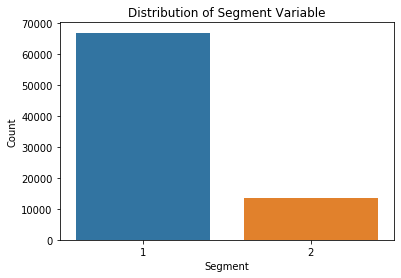

In [555]:
sns.countplot(train['segment'],order=train['segment'].value_counts().index)
plt.title("Distribution of Segment Variable")
plt.xlabel("Segment")
plt.ylabel("Count")
# Lot more values of Segment1 than Segment2

In [556]:
train['branch_id'].value_counts(dropna=False).head(10)
# All of the branch_id's have the same count i.e. 806 and this variable has 13504 missing values.

NaN       13504
 159.0      806
 17.0       806
 67.0       806
 269.0      806
 74.0       806
 268.0      806
 135.0      806
 62.0       806
 271.0      806
Name: branch_id, dtype: int64

In [557]:
print ("Number of Unique Branch_Id's in Training Data:{}".format(train['branch_id'].nunique()))
# 83 unique branch_id's in total in training dataset.

Number of Unique Branch_Id's in Training Data:83


(array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
        17, 18, 19]), <a list of 20 Text xticklabel objects>)

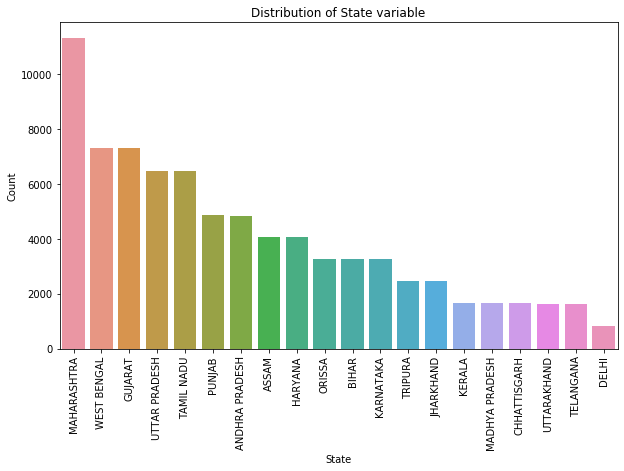

In [558]:
plt.figure(figsize=(10,6))
sns.countplot(train['state'],order=train['state'].value_counts(dropna=False).index)
plt.title("Distribution of State variable")
plt.xlabel("State")
plt.ylabel("Count")
plt.xticks(rotation=90)
# Maharashtra has the largest count followed by West Bengal and Gujarat, Delhi has the least count.

Text(0, 0.5, 'Count')

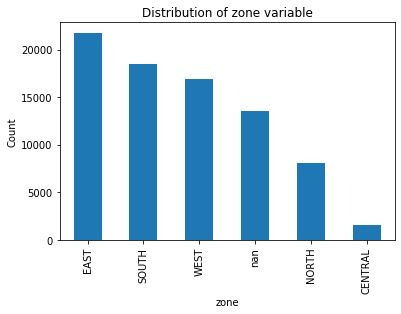

In [559]:
train['zone'].value_counts(dropna=False).plot(kind='bar')
plt.title("Distribution of zone variable")
plt.xlabel("zone")
plt.ylabel("Count")
# East has the highest count and Central has the least count, lot of missing values here.

In [560]:
train['case_count'].describe()

count    80402.000000
mean       185.481841
std        749.602925
min          0.000000
25%          0.000000
50%         18.000000
75%         60.000000
max      13787.000000
Name: case_count, dtype: float64

Some observations with respect to the dependent variable,
1. Maximum case count is 13787 which is exceptionally high.
2. Minimum case count is 0 which is understandable. 
3. Average value is 185 and the Median value is 18, so the distribution will be somewhat skewed. 

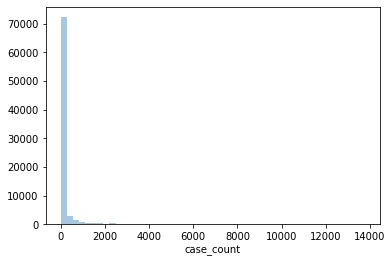

In [561]:
sns.distplot(train['case_count'],kde=False,bins=50)
# As we can see a lot of 0 values. 

In [562]:
train.head()

,application_date,segment,branch_id,state,zone,case_count
0,2017-04-01,1,1.0,WEST BENGAL,EAST,40.0
1,2017-04-03,1,1.0,WEST BENGAL,EAST,5.0
2,2017-04-04,1,1.0,WEST BENGAL,EAST,4.0
3,2017-04-05,1,1.0,WEST BENGAL,EAST,113.0
4,2017-04-07,1,1.0,WEST BENGAL,EAST,76.0


### Bi-Variate Analysis

In [563]:
train.groupby('segment')['case_count'].agg(['min','max','mean','median','std'])
# We can see that the Maximum value of case_count belongs to segment 2. 
# all these values for segment1 are higher than segment2.

,min,max,mean,median,std
segment,,,,,
1,0.0,1890.0,32.707106,14.0,61.591868
2,0.0,13787.0,942.318646,371.0,1624.339623


In [564]:
train.groupby('state')['case_count'].agg(['count','min','max','mean','median','std','sum']).sort_values(by='count')
# Although the count of Maharashtra is maximum, the sum of all case counts is maximum for Tamil Nadu.

,count,min,max,mean,median,std,sum
state,,,,,,,
DELHI,806,0.0,1488.0,168.486352,136.0,148.757794,135800.0
UTTARAKHAND,1612,0.0,383.0,24.782258,20.0,27.525605,39949.0
TELANGANA,1612,0.0,1038.0,56.153226,0.0,88.913544,90519.0
KERALA,1650,0.0,3369.0,496.008485,39.5,722.016808,818414.0
CHHATTISGARH,1650,0.0,1111.0,181.298788,22.5,241.012685,299143.0
MADHYA PRADESH,1650,0.0,2350.0,348.672121,87.0,455.859267,575309.0
TRIPURA,2456,0.0,997.0,82.313111,32.0,142.665541,202161.0
JHARKHAND,2456,0.0,833.0,69.036645,20.0,137.794878,169554.0
BIHAR,3262,0.0,7691.0,419.025445,25.0,1111.541528,1366861.0


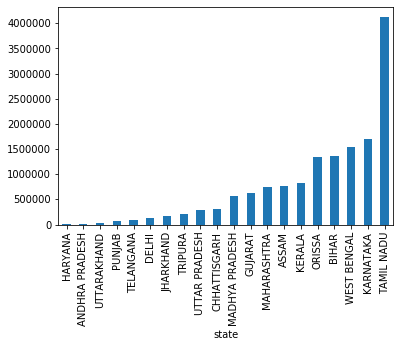

In [565]:
train.groupby('state')['case_count'].sum().sort_values().plot(kind='bar')

In [566]:
train.groupby('zone')['case_count'].agg(['count','min','max','mean','median','std','sum']).sort_values(by='count')
# Even here, although the count of East zone is maximum, but the total case_counts received in West zone is highest.

,count,min,max,mean,median,std,sum
zone,,,,,,,
CENTRAL,1612,0.0,609.0,23.082506,11.0,36.657118,37209.0
NORTH,8060,0.0,1488.0,27.383002,6.0,69.671582,220707.0
WEST,16926,0.0,1890.0,46.985053,23.0,77.373460,795269.0
SOUTH,18538,0.0,1143.0,26.973784,8.0,54.089844,500040.0
EAST,21762,0.0,1657.0,29.170802,16.0,48.989433,634815.0


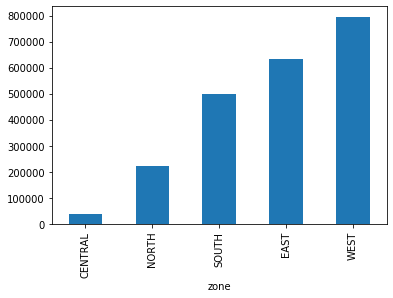

In [567]:
train.groupby('zone')['case_count'].sum().sort_values().plot(kind='bar')

In [568]:
# Let's create some additional datetime based features
train['year'] = train.application_date.dt.year
train['month'] = train.application_date.dt.month
train['dayofweek'] = train.application_date.dt.dayofweek
train['day'] = train.application_date.dt.day
train['quarter'] = train.application_date.dt.quarter
train['is_month_start'] = train.application_date.dt.is_month_start
train['is_month_end'] = train.application_date.dt.is_month_end
train['is_quarter_start'] = train.application_date.dt.is_quarter_start
train['is_quarter_end'] = train.application_date.dt.is_quarter_end

In [569]:
train.head()

,application_date,segment,branch_id,state,zone,case_count,year,month,dayofweek,day,quarter,is_month_start,is_month_end,is_quarter_start,is_quarter_end
0,2017-04-01,1,1.0,WEST BENGAL,EAST,40.0,2017,4,5,1,2,True,False,True,False
1,2017-04-03,1,1.0,WEST BENGAL,EAST,5.0,2017,4,0,3,2,False,False,False,False
2,2017-04-04,1,1.0,WEST BENGAL,EAST,4.0,2017,4,1,4,2,False,False,False,False
3,2017-04-05,1,1.0,WEST BENGAL,EAST,113.0,2017,4,2,5,2,False,False,False,False
4,2017-04-07,1,1.0,WEST BENGAL,EAST,76.0,2017,4,4,7,2,False,False,False,False


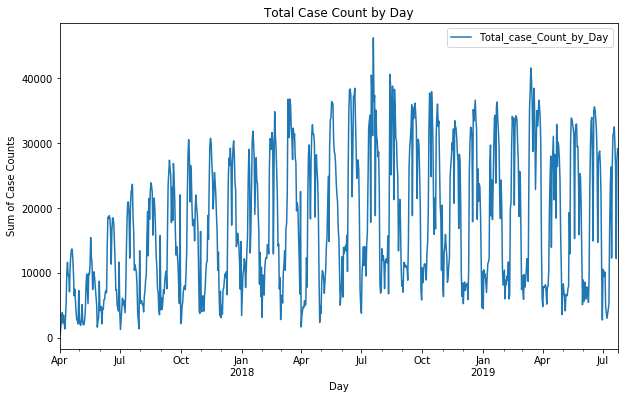

In [570]:
train.set_index('application_date').resample('D')['case_count'].sum().plot(kind='line',figsize=(10,6),label='Total_case_Count_by_Day')
plt.title("Total Case Count by Day")
plt.xlabel('Day')
plt.ylabel("Sum of Case Counts")
plt.legend(loc='best')
# We can see some kind of trend here, the sum total of case counts increases for sometime and then stays almost same. 
# We can also see a spike that is apart from the trend around July-Oct of 2018.

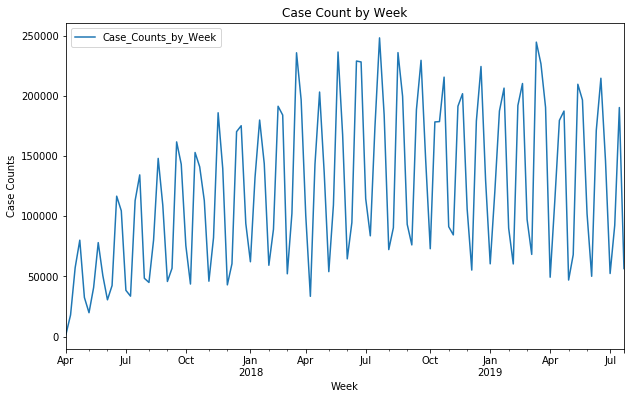

In [571]:
train.set_index('application_date').resample('W')['case_count'].sum().plot(kind='line',figsize=(10,6),label='Case_Counts_by_Week')
plt.title("Case Count by Week")
plt.xlabel('Week')
plt.ylabel("Case Counts")
plt.legend(loc='best')
# We can see increasing and decreasing trends here

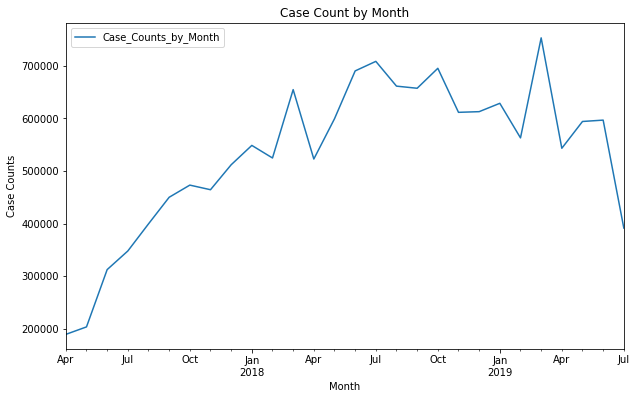

In [572]:
train.set_index('application_date').resample('M')['case_count'].sum().plot(kind='line',figsize=(10,6),label='Case_Counts_by_Month')
plt.title("Case Count by Month")
plt.xlabel('Month')
plt.ylabel("Case Counts")
plt.legend(loc='best')
# We can see a gradual increase for sometime and then series of increasing and decreasing trends followed by a dip at the end

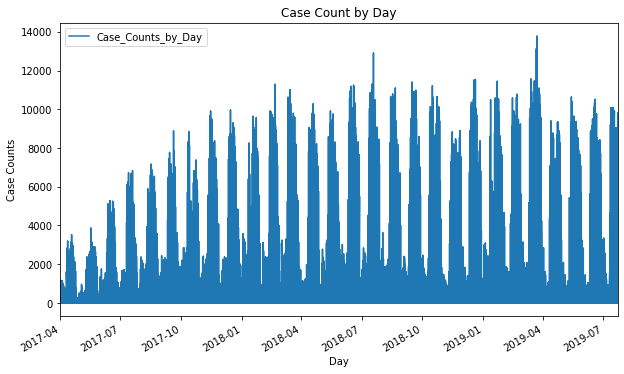

In [573]:
train.set_index('application_date')['case_count'].plot(kind='line',figsize=(10,6),label='Case_Counts_by_Day')
plt.title("Case Count by Day")
plt.xlabel('Day')
plt.ylabel("Case Counts")
plt.legend(loc='best')
# We can see increasing and decreasing trends here

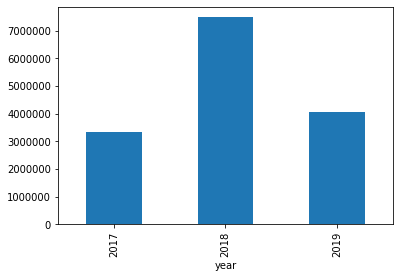

In [574]:
train.groupby('year')['case_count'].sum().sort_index().plot(kind='bar')
# we can see a spike in the total case counts from 2017 to 2018

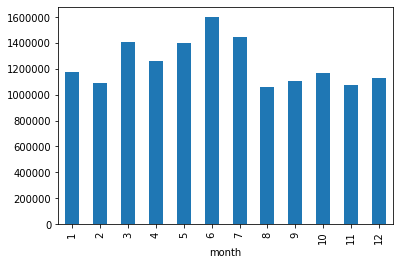

In [575]:
train.groupby('month')['case_count'].sum().sort_index().plot(kind='bar')
# case_count sum is maximum during the month of June followed by July,March and May which are close to each other. It is minimum
# in the month of August.

In [576]:
train.groupby('dayofweek')['case_count'].agg(['count','min','max','sum','mean']).sort_values(by='count')
# Thursday has the highest occurence and Sunday has the least. 
# Wednesday has the highest sum total of case counts.

,count,min,max,sum,mean
dayofweek,,,,,
6,11149,0.0,10250.0,1436647.0,128.858821
5,11398,0.0,13787.0,2135403.0,187.348921
2,11548,0.0,11160.0,2314316.0,200.408382
4,11548,0.0,13118.0,2262137.0,195.889938
0,11564,0.0,10805.0,2173422.0,187.947250
1,11564,0.0,11506.0,2280995.0,197.249654
3,11631,0.0,12908.0,2310191.0,198.623592


In [577]:
train.groupby(['year','quarter'])['case_count'].agg(['count','min','max','sum','mean'])
# Count is maximum during the 4th Quarter of 2017 and 3rd and 4th quarter of 2018.
# Sum is maximum during 3rd quarter of 2017.

count  min      max        sum        mean
year quarter                                            
2017 2         8428  0.0   5274.0   706232.0   83.795918
     3         8361  0.0   8884.0  1197941.0  143.277240
     4         9108  0.0   9963.0  1449814.0  159.180281
2018 1         8578  0.0  11288.0  1728408.0  201.493122
     2         9009  0.0  11241.0  1812629.0  201.202020
     3         9108  0.0  12908.0  2027253.0  222.579381
     4         9108  0.0  11536.0  1919816.0  210.783487
2019 1         8910  0.0  13787.0  1944961.0  218.289675
     2         9009  0.0  10629.0  1734401.0  192.518704
     3          783  0.0  10099.0   391656.0  500.199234

In [578]:
test['year'] = test.application_date.dt.year
test['month'] = test.application_date.dt.month
test['dayofweek'] = test.application_date.dt.dayofweek
test['day'] = test.application_date.dt.day
test['quarter'] = test.application_date.dt.quarter
test['is_month_start'] = test.application_date.dt.is_month_start
test['is_month_end'] = test.application_date.dt.is_month_end
test['is_quarter_start'] = test.application_date.dt.is_quarter_start
test['is_quarter_end'] = test.application_date.dt.is_quarter_end

In [579]:
train.head()

,application_date,segment,branch_id,state,zone,case_count,year,month,dayofweek,day,quarter,is_month_start,is_month_end,is_quarter_start,is_quarter_end
0,2017-04-01,1,1.0,WEST BENGAL,EAST,40.0,2017,4,5,1,2,True,False,True,False
1,2017-04-03,1,1.0,WEST BENGAL,EAST,5.0,2017,4,0,3,2,False,False,False,False
2,2017-04-04,1,1.0,WEST BENGAL,EAST,4.0,2017,4,1,4,2,False,False,False,False
3,2017-04-05,1,1.0,WEST BENGAL,EAST,113.0,2017,4,2,5,2,False,False,False,False
4,2017-04-07,1,1.0,WEST BENGAL,EAST,76.0,2017,4,4,7,2,False,False,False,False


In [580]:
test.head()

,application_date,segment,year,month,dayofweek,day,quarter,is_month_start,is_month_end,is_quarter_start,is_quarter_end
0,2019-07-06,1,2019,7,5,6,3,False,False,False,False
1,2019-07-07,1,2019,7,6,7,3,False,False,False,False
2,2019-07-08,1,2019,7,0,8,3,False,False,False,False
3,2019-07-09,1,2019,7,1,9,3,False,False,False,False
4,2019-07-10,1,2019,7,2,10,3,False,False,False,False


#### Defining the Evaluation Metric

In [581]:
def mean_absolute_percentage_error(y_true, y_pred): 
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    return np.mean(np.abs((y_pred - y_true) / y_pred)) * 100

my_scorer = make_scorer(mean_absolute_percentage_error)

#### Model Building

1. Since we are supposed to forecast sum of case counts at Country level, it makes sense to create dataframe using the current train and test dataframes. 
2. We can also create additional feature like we did earlier using this new dataframe.

In [582]:
df_train = train.groupby(['application_date','segment'],as_index=False)['case_count'].sum()
df_train.shape

(1650, 3)

In [583]:
# defining a function to create a weekend indicator
def weekend_indicator(x):
    if (x>4 and x<=6):
        return True
    else:
        return False

In [584]:
df_train['year'] = df_train.application_date.dt.year
df_train['month'] = df_train.application_date.dt.month
df_train['dayofweek'] = df_train.application_date.dt.dayofweek
df_train['day'] = df_train.application_date.dt.day
df_train['quarter'] = df_train.application_date.dt.quarter
df_train['is_month_start'] = df_train.application_date.dt.is_month_start
df_train['is_month_end'] = df_train.application_date.dt.is_month_end
df_train['is_quarter_start'] = df_train.application_date.dt.is_quarter_start
df_train['is_quarter_end'] = df_train.application_date.dt.is_quarter_end
df_train['weekend'] = df_train.dayofweek.apply(weekend_indicator)

test['weekend'] = test.dayofweek.apply(weekend_indicator)

In [585]:
X = df_train[[col for col in df_train.columns if col not in ['application_date','case_count']]]
y = df_train['case_count']

In [586]:
cols = ['year','month','dayofweek','day','quarter']
for col in cols:
    df_train[col] = df_train[col].astype('category')
    test[col] = test[col].astype('category')

In [587]:
X_Train,X_Test,y_Train,y_Test = train_test_split(X,y,test_size=0.25,random_state=42)
print (X_Train.shape)
print (y_Train.shape)
print (X_Test.shape)
print (y_Test.shape)

(1237, 11)
(1237,)
(413, 11)
(413,)


In [588]:
"""
kf = KFold(n_splits=4,random_state=42)
scores = []
models = []
for train_index,test_index in kf.split(X,y):
    train_features = X.iloc[train_index]
    train_target = y.iloc[train_index]
    
    test_features = X.iloc[test_index]
    test_target = y.iloc[test_index]
    
    model = RandomForestRegressor(n_jobs=1, random_state=42,n_estimators=2000,min_samples_leaf=2)
    model.fit(train_features,train_target)
    models.append(model)
    y_predict = model.predict(test_features)
    scores.append(mean_absolute_percentage_error(test_target,y_predict))
print (scores)"""

'\nkf = KFold(n_splits=4,random_state=42)\nscores = []\nmodels = []\nfor train_index,test_index in kf.split(X,y):\n    train_features = X.iloc[train_index]\n    train_target = y.iloc[train_index]\n    \n    test_features = X.iloc[test_index]\n    test_target = y.iloc[test_index]\n    \n    model = RandomForestRegressor(n_jobs=1, random_state=42,n_estimators=2000,min_samples_leaf=2)\n    model.fit(train_features,train_target)\n    models.append(model)\n    y_predict = model.predict(test_features)\n    scores.append(mean_absolute_percentage_error(test_target,y_predict))\nprint (scores)'

In [589]:
test.drop('application_date',axis=1,inplace=True)

In [590]:
"""stepsize = 10
results = np.zeros(test.shape[0])
for model in models:
    predictions = []
    for i in range(0, test.shape[0], stepsize):
        predictions.append(model.predict(test.loc[i:i+stepsize-1,:]))
    results += (1 / len(models)) * np.concatenate(predictions, axis=0)
    del(model)"""

'stepsize = 10\nresults = np.zeros(test.shape[0])\nfor model in models:\n    predictions = []\n    for i in range(0, test.shape[0], stepsize):\n        predictions.append(model.predict(test.loc[i:i+stepsize-1,:]))\n    results += (1 / len(models)) * np.concatenate(predictions, axis=0)\n    del(model)'

In [591]:
rf = RandomForestRegressor(n_jobs=1, random_state=42,n_estimators=2000,min_samples_leaf=2,max_depth=11)
rf.fit(X_Train,y_Train)
y_pred = rf.predict(X_Test)
print (mean_absolute_percentage_error(y_Test,y_pred))

25.88742192236813


In [592]:
Submission['case_count'] = rf.predict(test)
Submission['case_count'] = Submission['case_count'].astype(int)
Submission.to_csv("Submission.csv",index=None)
Submission.head()

,id,application_date,segment,case_count
0,1,2019-07-06,1,2409
1,2,2019-07-07,1,1655
2,3,2019-07-08,1,4045
3,4,2019-07-09,1,3518
4,5,2019-07-10,1,3548
